In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from pprint import pprint
from pylab import plt, mpl

首先，自动生成一个仅含有整数的连续数据串，即：从0到99的连续整数

In [2]:
a = np.arange(100)

In [3]:
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

然后，将这个整数序列转成合适的格式，我们输出前面5个看下转换后的效果

In [4]:
a = a.reshape(len(a),1)

In [5]:
a.shape

(100, 1)

In [6]:
a[:5]

array([[0],
       [1],
       [2],
       [3],
       [4]])

接着，再用TimeseriesGenerator函数，将原始的整数序列转换称适合RNN训练的数据格式。它的基本逻辑是，我们用过去lag个值作为输入，放入模型训练，然后预测N+1的值。并且以此类推，比如用前0、1、2个值预测第4个值（N=3），用1、2、3预测第4个值（N=4）。这里的lag也是我们之前在传统统计模型里用到的步长。

这样做的一个好处是，可以把转换后的数据作为训练集直接放入模型中训练，而不用再将训练集拆分成feature和label两列。

In [7]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [8]:
lags = 3 

In [9]:
g = TimeseriesGenerator(a, a, length=lags, batch_size=5)

In [72]:
g[0]

(array([[[0],
         [1],
         [2]],
 
        [[1],
         [2],
         [3]],
 
        [[2],
         [3],
         [4]],
 
        [[3],
         [4],
         [5]],
 
        [[4],
         [5],
         [6]]]),
 array([[3],
        [4],
        [5],
        [6],
        [7]]))

In [11]:
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

In [25]:
model = Sequential()
model.add(SimpleRNN(200, activation='relu', input_shape=(lags, 1)))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adagrad', loss='mse', metrics=['mae'])

这里先设置一个有200个神经元的SimpleRNN模型，输入变量的步长等于之前设置的lag值，即：input_shape=(lags, 1)。

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 200)               40400     
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 40,601
Trainable params: 40,601
Non-trainable params: 0
_________________________________________________________________


In [41]:
%%time
model.fit(g, epochs=2000, steps_per_epoch=5, verbose=False)

CPU times: total: 1min 13s
Wall time: 54.7 s


可以看到，对模拟的整数序列大概花了37秒多的时间训练。从loss和mae的值来看，模型的收敛并不是很好，估计样本外的准确率也不会太高。

In [42]:
res = pd.DataFrame(model.history.history)

In [43]:
res.tail(3)

,loss,mae
1997,0.049773,0.207862
1998,0.039646,0.148919
1999,0.018442,0.126532


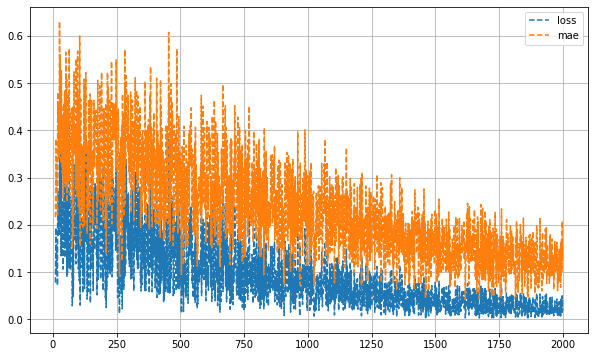

In [81]:
res.iloc[10:].plot(figsize=(10, 6), style=['--', '--']);
plt.grid()

用这个训练好的模型，我们可以做些样本内和样本外的测试，看看预测效果。首先要将输入X，用reshape函数转换成三维矩阵。

In [63]:
x = np.array([21, 22, 23]).reshape((1, lags, 1))

In [51]:
y = model.predict(x, verbose=False)
int(round(y[0,0]))

24

In [52]:
x = np.array([87, 88, 89]).reshape((1, lags, 1))
y = model.predict(x, verbose=False)
int(round(y[0, 0]))

90

In [53]:
x = np.array([1187, 1188, 1189]).reshape((1, lags, 1))
y = model.predict(x, verbose=False)
int(round(y[0, 0]))

1201

可以看到，样本内测试的准确率是100%，但样本外的准确率比较低。即使有200个神经元的SimpleRNN模型，并不能很好的预测未来的走势。

In [73]:
def transform(x):
    y = 0.05 * x ** 2 + 0.2 * x + np.sin(x) + 5
    y += np.random.standard_normal(len(x)) * 0.2
    return y

下面我们再试一个例子：设定x为一个【− 2π, 2π】的区间离散数组。

In [75]:
x = np.linspace(-2 * np.pi, 2 * np.pi, 500)

接着，再将这个x带入一个二次方程式、并加上一个sin的三角函数；并将算出来的y值加上一些白噪音，形成我们最终模拟出的一个时间序列数组。整个数据大概的样子如图所示，有点像股价的走势图。

In [ ]:
def transform(x):
    y = 0.05 * x ** 2 + 0.2 * x + np.sin(x) + 5
    y += np.random.standard_normal(len(x)) * 0.2
    return y

In [78]:
a = transform(x)
a[:5]

array([5.62180119, 5.64863   , 5.8114604 , 5.8196801 , 5.97055075])

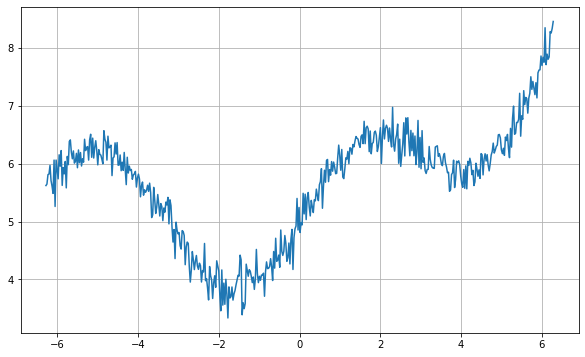

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(x, a)
plt.grid()

再按之前的做法，将时间序列数组转化为RNN需要的矩阵形式，具体操作如下：

In [88]:
a = a.reshape((len(a), -1))
lags = 10
g = TimeseriesGenerator(a, a, length=lags, batch_size=5)

In [83]:
model = Sequential()
model.add(SimpleRNN(500, activation='relu', input_shape=(lags, 1)))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [84]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 500)               251000    
                                                                 
 dense_2 (Dense)             (None, 1)                 501       
                                                                 
Total params: 251,501
Trainable params: 251,501
Non-trainable params: 0
_________________________________________________________________


In [85]:
%%time
model.fit(g, epochs=2000, steps_per_epoch=10, verbose=False)

CPU times: total: 8min 45s
Wall time: 1min 51s


In [86]:
res = pd.DataFrame(model.history.history)
res.tail(3)

,loss,mae
1997,0.060758,0.199045
1998,0.040749,0.167692
1999,0.072725,0.209278


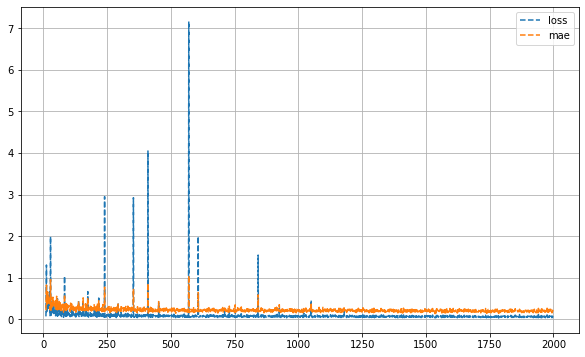

In [87]:
res.iloc[10:].plot(figsize=(10, 6), style=['--', '--']);
plt.grid()

上述RNN模型在x等于【− 2π, 2π】的区间上做了训练，接着我们将其放在【− 6π, 6π】的区间进行测试。显然这个区间的两头，即小于− 2π和大于2π的部分为样本外数据。

In [89]:
x = np.linspace(-6 * np.pi, 6 * np.pi, 500)
d = transform(x)

In [97]:
g_hat = TimeseriesGenerator(d, d, length=lags, batch_size=len(d))

In [98]:
f = list(g_hat)[0][0].reshape((len(d) - lags, lags, 1))

In [93]:
y = model.predict(f, verbose=False)

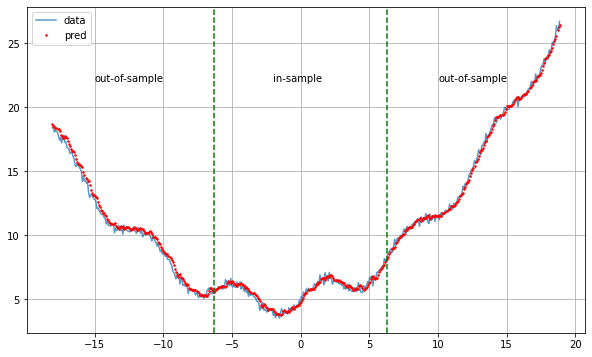

In [94]:
plt.figure(figsize=(10, 6))
plt.plot(x[lags:], d[lags:], label='data', alpha=0.75)
plt.plot(x[lags:], y, 'r.', label='pred', ms=3)
plt.axvline(-2 * np.pi, c='g', ls='--')
plt.axvline(2 * np.pi, c='g', ls='--')
plt.text(-15, 22, 'out-of-sample')
plt.text(-2, 22, 'in-sample')
plt.text(10, 22, 'out-of-sample')
plt.legend();
plt.grid()